In [309]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [321]:
%%time
df = pd.read_excel('nyc_benchmarking_disclosure_2017_consumption_data.xlsx',
            'Information and Metrics', usecols='P, T, Y, Z, AA, BA')

CPU times: total: 11.1 s
Wall time: 11.3 s


In [322]:
for c in df.columns:
    df = df[df[c].notna()]

In [323]:
frames = list()
names = list()
for c in df.columns:
    if c == 'Total GHG Emissions (Metric Tons CO2e)':
        continue
    frames.append(df[c])
    names.append(c)
dfx = pd.concat(frames, axis=1)
x = np.array(dfx[names])
# yEl = np.array(df['Electricity Use'].fillna(0)).reshape(-1, 1)

yEm = np.array(df['Total GHG Emissions (Metric Tons CO2e)']).reshape(-1, 1)

In [324]:
regEm = LinearRegression().fit(x, yEm)
# regEl = LinearRegression().fit(x, yEl)

In [ ]:
record = list()
outlierCounter = 0
for index in range(len(df)):
    vals = list(df.iloc[index].fillna(0))
    prediction = np.array(vals[:len(df.columns)-1]).reshape(1, -1)
    predEm = regEm.predict(prediction)[0][0]
    
    if df.iloc[index][len(df.columns)-1] == 0:
        continue
    
    # print(df.iloc[index])
    print('PREDICTED GHG EMISSIONS:', predEm)
    print('ACTUAL GHG EMISSIONS:', round(df.iloc[index][len(df.columns)-1]))
    print('ABS PERCENT ERROR:', abs(round((predEm - df.iloc[index][len(df.columns)-1]) / df.iloc[index][len(df.columns)-1] * 100)), '%')
    print()
    record.append(abs(round((predEm - df.iloc[index][len(df.columns)-1]) / df.iloc[index][len(df.columns)-1] * 100)))
    
print()
print(sum(record) / len(record))
print(outlierCounter)

(0.0, 100000.0)

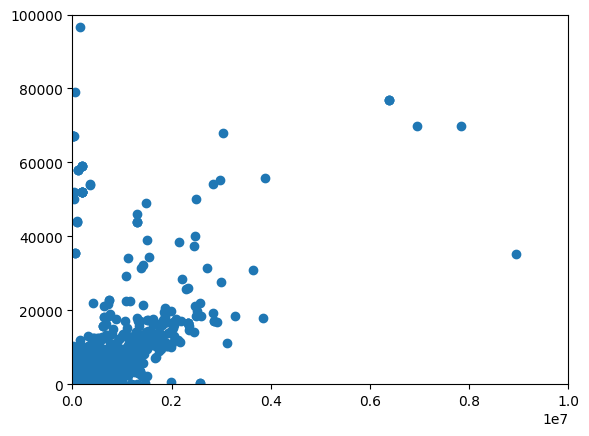

In [315]:
p = plt.scatter(df['Self-Reported Gross Floor Area (ft²)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 10000000)
plt.ylim(0, 100000)

(0.0, 100000.0)

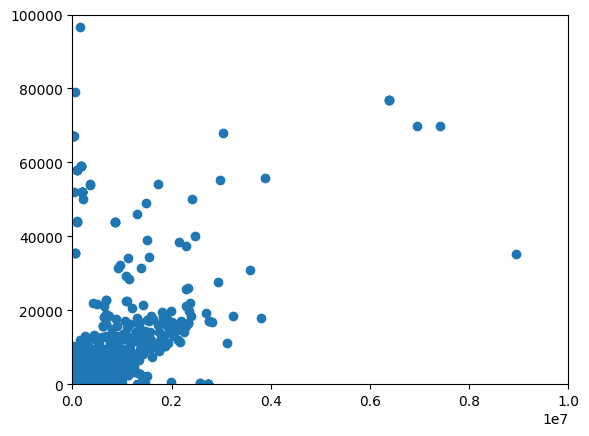

In [316]:
p = plt.scatter(df['Largest Property Use Type - Gross Floor Area (ft²)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 10000000)
plt.ylim(0, 100000)

(0.0, 100000.0)

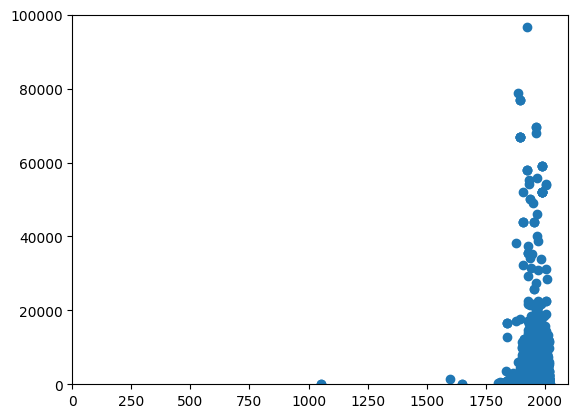

In [317]:
p = plt.scatter(df['Year Built'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 2100)
plt.ylim(0, 100000)

(0.0, 100000.0)

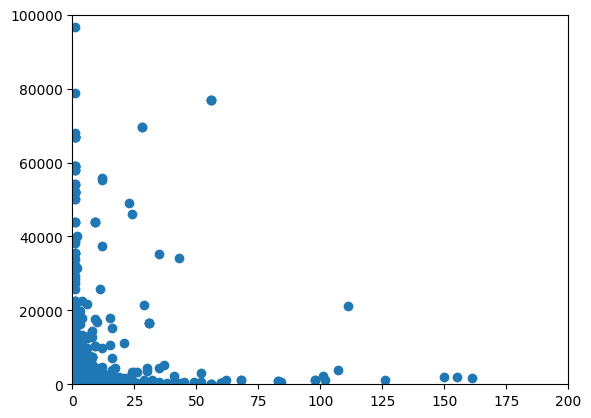

In [159]:
p = plt.scatter(df['Number of Buildings'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 200)
plt.ylim(0, 100000)

(0.0, 100000.0)

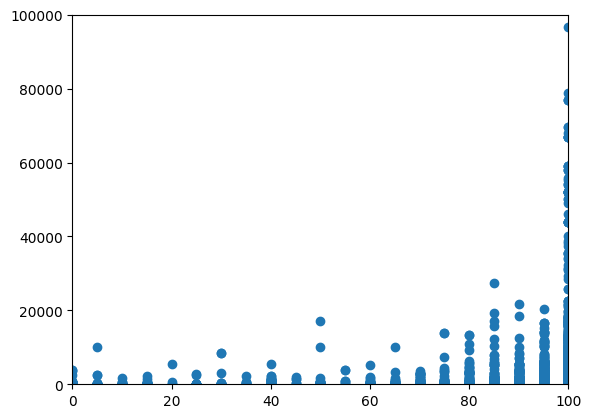

In [291]:
p = plt.scatter(df['Occupancy'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 100)
plt.ylim(0, 100000)